In [1]:
import sys
import os

project_root = os.path.abspath('..')
sys.path.append(project_root)

In [2]:
from models.human import Human
from models.population import Population
from visualization.interbreeding_visualizer import InterbreedingVisualizer

import matplotlib as mpl
import matplotlib.pyplot as plt

Модель **Population** представляет собой симуляцию человеческой популяции, включающую возможность эволюции (изменения) популяции с течением времени. Основная цель модели — отслеживать демографические показатели (рост численности, возрастной состав, генетическое разнообразие) и поведение популяции.

##### Основные характеристики модели:
Члены популяции:

Каждый представитель (экземпляр класса `Human`) обладает следующими признаками:
- Пол (gender): мужской (male) / женский (female).
- Возраст (age)
- Генотип (genotype): набор генетических компонентов, характеризующий его расовый состав.
- Количество детей (number_of_children): отслеживает потомство данного человека.

##### Настройки популяции (population_settings):

- Вероятность рождения ребенка (birth_probability) - функция, описывающая вероятность в течение года рождения ребенка женщиной, в зависимости от возраста и, возможно, некоторых других параметров 
- Вероятность смерти (death_probability)  - функция, описывающая вероятность в течение года смерти, в зависимости от возраста, пола и, возможно, некоторых других параметров
- Соотношение полов при рождении (gender_ratio_at_birth).
- Фертильные возрастные диапазоны для мужчин и женщин:
  - Женщины (female_fertile_age_range).
  - Мужчины (male_fertile_age_range).
- Первоначальное распределение генетических компонентов (рас) (initial_race_distribution).
- Начальное возрастное распределение (initial_age_distribution).
Эти настройки передаются в класс `Population` в словаре `population_settings`

##### Методы управления популяцией:

`generate_population(size)`: Создает популяцию из указанного количества членов с учетом заданных распределений возраста, пола и генетики.
`evolve(years)`: Симулирует эволюцию популяции на указанное число лет.

##### Сохранение истории:

Хранится история изменения численности мужчин и женщин в популяции (male_history, female_history).

##### Сбор статистики:

Метод `stat` возвращает ключевую статистику:
- Число прошедших лет.
- Размер популяции.
- Средний годовой темп прироста (в процентах).
- Минимальный, максимальный и средний возраст.
- и т.д.
  
##### Случайные события:

Генерация распределения по возрасту, полу и генетике основана на неких задаваемых изначально вероятностых моделях - в зависимости от сценария, который интересует.
###### Пример поведения:
Например, можно создать популяцию из 1000 человек с заданными параметрами (например, 50% мужчин и 50% женщин, начальное распределение возраста и генетики).
Популяция будет эволюционировать, демонстрируя процессы рождения, смерти и генетического смешивания.
После заданного времени можно получить статистику, чтобы оценить изменения (например, как изменился генетический состав, возрастной профиль и рост популяции).
Модель подходит для изучения эволюции популяции в различных условиях, включая анализ влияния демографических факторов, таких как смертность, рождаемость, возрастной состав и генетическое разнообразие.

In [4]:
def calculate_birth_probability(human, fertile_age_range, max_children_number=4):
    """
    Прогнозирует вероятность рождения женщиной ребенка в течение года.
|
    :param human: Объект Human
    :param fertile_age_range: tuple. Диапазон фертильного возраста, например (17, 50).
    :return: float. Вероятность рождения ребенка в течение года.
    """
    CALIBRATION_COEFFICIENT = 0.79
    age = human.age
    number_of_children = human.number_of_children

    min_fertile_age, max_fertile_age = fertile_age_range
    if age < min_fertile_age or age > max_fertile_age:
        return 0.0
    age_specific_fertility = {
        (min_fertile_age, 19): 0.10,  # 10% в год
        (20, 24): 0.18,               # 18% в год
        (25, 29): 0.20,               # 20% в год
        (30, 34): 0.15,               # 15% в год
        (35, 39): 0.10,               # 10% в год
        (40, 44): 0.05,               # 5% в год
        (45, max_fertile_age): 0.01,  # 1% в год
    }

    base_probability = 0.0
    for age_range, probability in age_specific_fertility.items():
        if age_range[0] <= age <= age_range[1]:
            base_probability = probability
            break

    children_penalty = 1.0 / max_children_number
    adjusted_probability = max(0.0, base_probability * (1 - children_penalty * number_of_children))

    adjusted_probability *= CALIBRATION_COEFFICIENT
    return adjusted_probability

In [5]:
def calculate_death_probability(human, max_age=100):
    """
    Вычисляет вероятность смерти человека за год на основе его возраста и пола.

    :param human: Объект Human
    :param max_age: Максимальный возраст, после которого вероятность смерти считается равной 1.
    :return: Вероятность смерти за год (значение от 0.0 до 1.0).
    """
    age = human.age
    gender = human.gender
    
    if age < 1:
        return 0.005
    elif age < 15:
        return 0.0002
    elif age < 40:
        base_rate = 0.0003 if gender == "female" else 0.0004
        return base_rate + age * 0.00002
    elif age < 60:
        base_rate = 0.002 if gender == "female" else 0.003
        return base_rate + (age - 40) * 0.0001
    elif age < max_age:
        base_rate = 0.1 if gender == "female" else 0.15
        return min(1.0, base_rate + (age - 60) * 0.005)
    return 1.0

In [6]:
POPULATION_SETTINGS = {
    "fertile_age_range": {
        "female": (17, 50),
        "male": (12, 70)
    },
    'initial_race_distribution': {
        "green": 0.50,
        "brown": 0.50
    },
    "initial_age_distribution": {
        (0, 14): 0.17,   # 17% детей
        (15, 24): 0.12,  # 12% подростков и молодых взрослых
        (25, 54): 0.40,  # 40% трудоспособного населения
        (55, 64): 0.13,  # 13% предпенсионного возраста
        (65, 79): 0.14,  # 14% пожилых людей (младшие пенсионеры)
        (80, 90): 0.04   # 4% старших пожилых людей
    },
    'gender_ratio_at_birth': {
        "male": 0.512,   # 51.2% новорожденных — мальчики
        "female": 0.488  # 48.8% новорожденных — девочки
    },
    'max_age': 90,
    'birth_probability': calculate_birth_probability,
    'death_probability': calculate_death_probability
}

In [7]:
POPULATION_INIT_SIZE = 1_000
population = Population(POPULATION_SETTINGS)
population.generate_population(POPULATION_INIT_SIZE)
visualizer = InterbreedingVisualizer(population)

population.stat

{'elapsed_years': 0,
 'population_size': 1000,
 'annual_growth_rate_percent': None,
 'min_age': 0,
 'max_age': 90,
 'average_age': 40.3,
 'gender_ratio': {'male': 492, 'female': 508, 'male_per_female_ratio': 1.0},
 'green_mean': 0.49,
 'green_std_dev': 0.5,
 'brown_mean': 0.51,
 'brown_std_dev': 0.5}

In [11]:
population.evolve(100)
population.stat

{'elapsed_years': 200,
 'population_size': 999,
 'annual_growth_rate_percent': -0.001,
 'min_age': 0,
 'max_age': 84,
 'average_age': 32.1,
 'gender_ratio': {'male': 512, 'female': 487, 'male_per_female_ratio': 1.1},
 'green_mean': 0.51,
 'green_std_dev': 0.07,
 'brown_mean': 0.49,
 'brown_std_dev': 0.07}

AttributeError: 'Population' object has no attribute 'male_history'

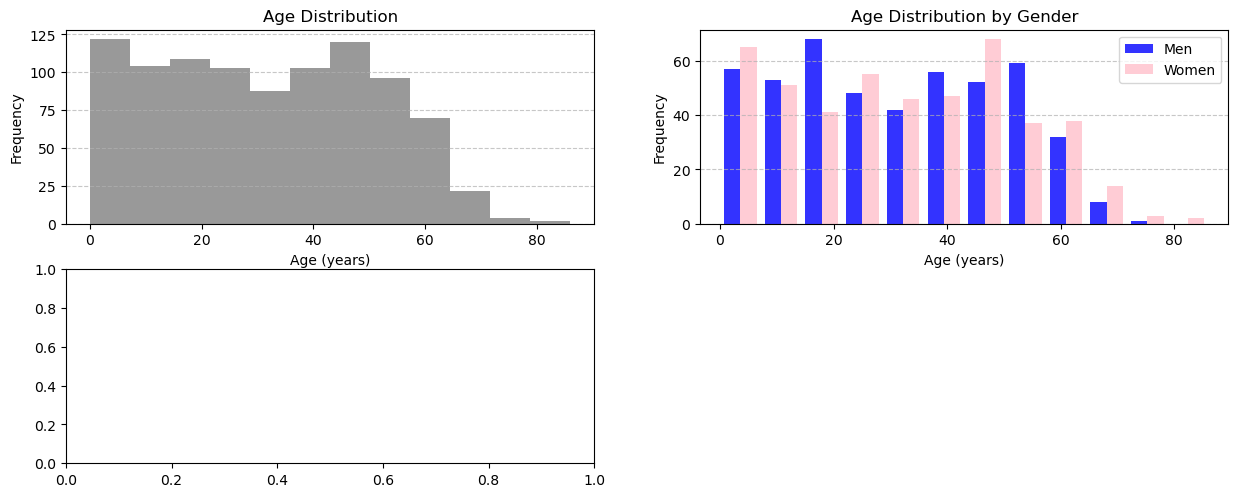

In [9]:
visualizer.plot_all()

In [30]:
population.evolve(200)
population.stat

{'elapsed_years': 200,
 'population_size': 837,
 'annual_growth_rate_percent': -0.089,
 'min_age': 0,
 'max_age': 78,
 'average_age': 31.56989247311828,
 'gender_ratio': {'male': 433,
  'female': 404,
  'male_per_female_ratio': 1.0717821782178218}}

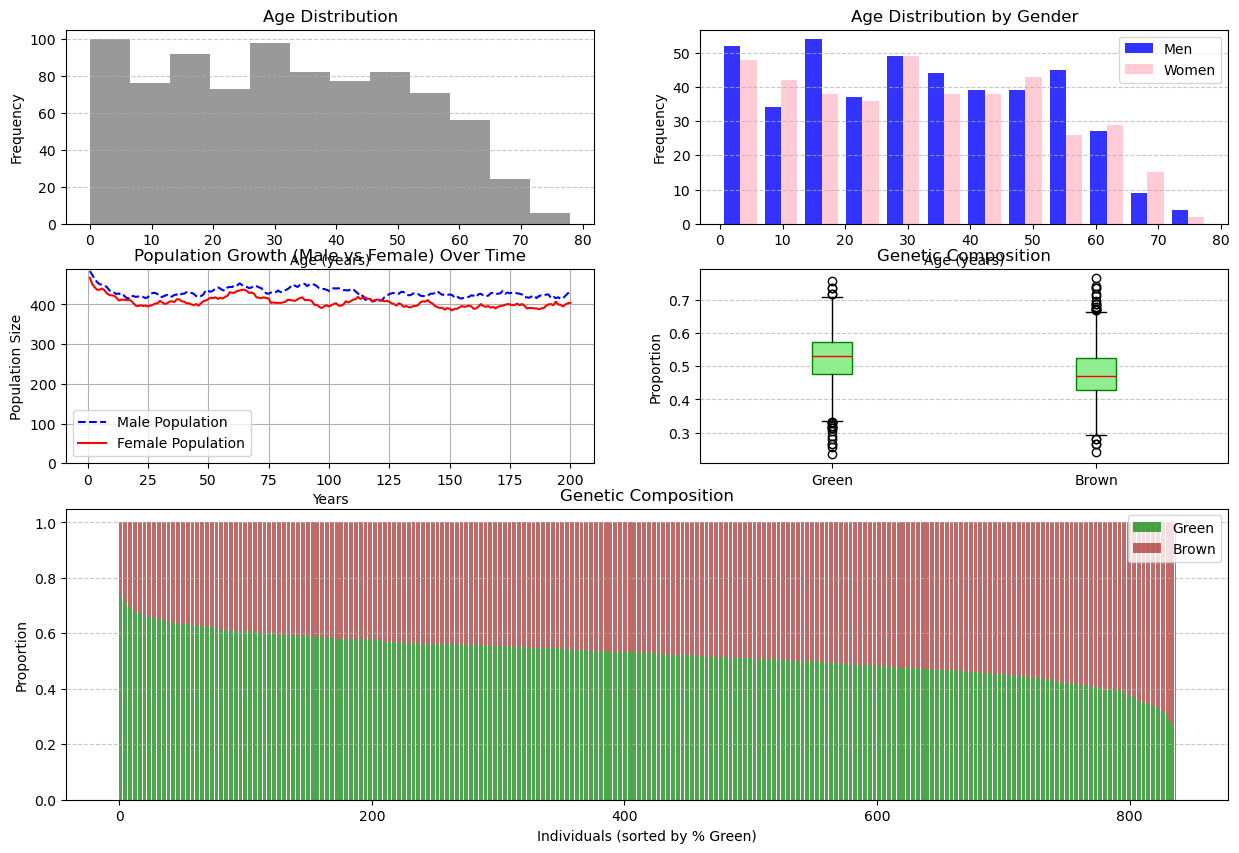

In [32]:
visualizer.plot_all()

In [65]:
population.evolve(300)
population.stat

{'elapsed_years': 400,
 'population_size': 1352,
 'annual_growth_rate_percent': 0.075,
 'min_age': 0,
 'max_age': 82,
 'average_age': 30.875739644970412,
 'gender_ratio': {'male': 680, 'female': 672, 'ratio': 1.0119047619047619}}

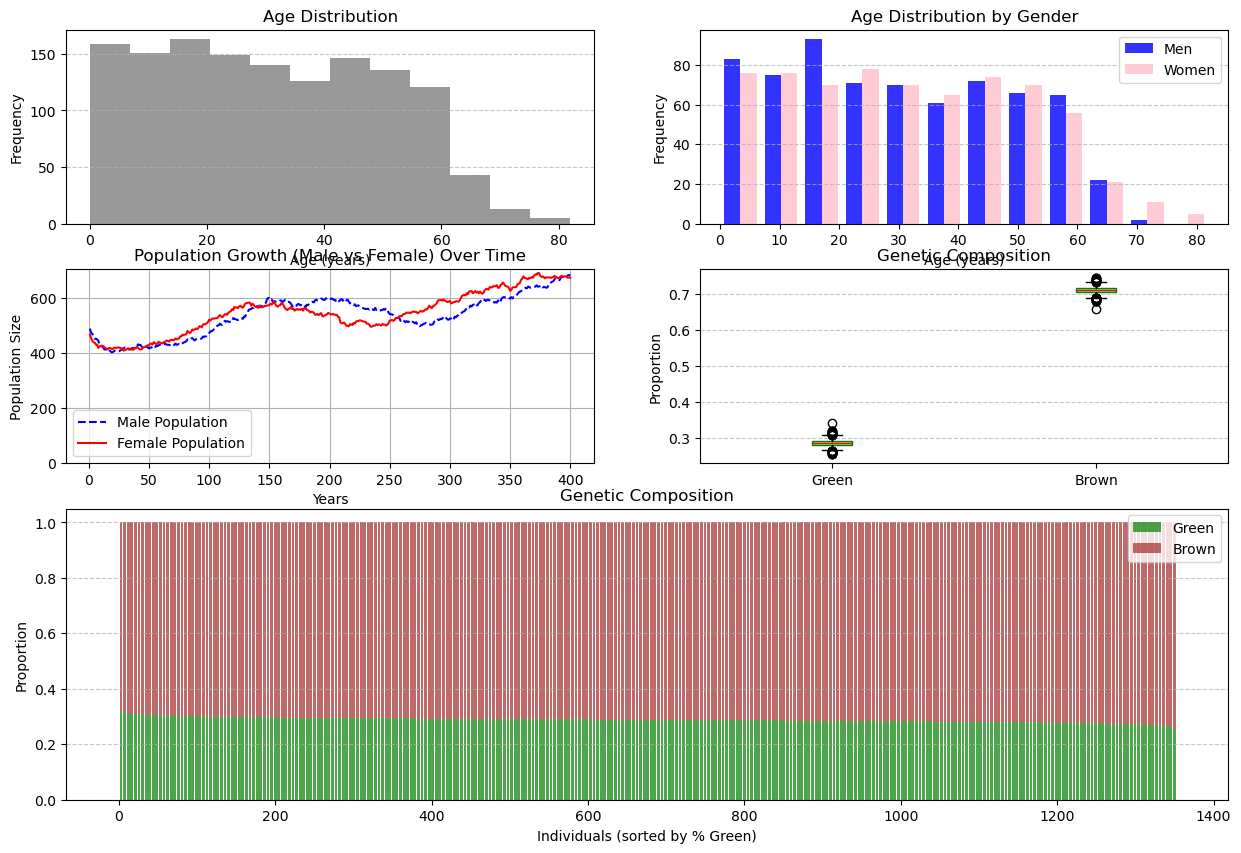

In [67]:
visualizer.plot_all()

### Случай с неравной скоростью воспроизводства:
#### вероятность рождения у black в два раза выше, чем у green
#### начальное распеделение у black и green одинаково

In [89]:
def calculate_birth_probability_with_race_bias(
    human, 
    fertile_age_range, 
    max_children_number=4
):
    """
    Прогнозирует вероятность рождения женщиной ребенка в течение года с учетом расового коэффициента.

    :param human: Объект Human.
    :param fertile_age_range: tuple. Диапазон фертильного возраста, например (17, 50).
    :param max_children_number: int. Максимальное количество детей, после которого вероятность рождения 
                                уменьшается на основе штрафного коэффициента.
    :param preferred_race: str. Раса с повышенным коэффициентом рождаемости.
    :param race_bias_coefficient: float. Коэффициент увеличения/уменьшения базовой вероятности для выбранной расы.
    :return: float. Вероятность рождения ребенка в течение года.
    """
    CALIBRATION_COEFFICIENT = 0.79
    age = human.age
    number_of_children = human.number_of_children

    min_fertile_age, max_fertile_age = fertile_age_range
    if age < min_fertile_age or age > max_fertile_age:
        return 0.0

    age_specific_fertility = {
        (min_fertile_age, 19): 0.10,  # 10% в год
        (20, 24): 0.18,               # 18% в год
        (25, 29): 0.20,               # 20% в год
        (30, 34): 0.15,               # 15% в год
        (35, 39): 0.10,               # 10% в год
        (40, 44): 0.05,               # 5% в год
        (45, max_fertile_age): 0.01,  # 1% в год
    }

    base_probability = 0.0
    for age_range, probability in age_specific_fertility.items():
        if age_range[0] <= age <= age_range[1]:
            base_probability = probability
            break

    if human.genotype['brown'] > human.genotype['green']:
        base_probability *= 1.25
    else:
        base_probability = 0

    children_penalty = 1.0 / max_children_number
    adjusted_probability = max(0.0, base_probability * (1 - children_penalty * number_of_children))

    adjusted_probability *= CALIBRATION_COEFFICIENT
    return adjusted_probability


In [91]:
population_settings = POPULATION_SETTINGS | {'birth_probability': calculate_birth_probability_with_race_bias}

In [93]:
POPULATION_INIT_SIZE = 1_000
population = Population(population_settings)
population.generate_population(POPULATION_INIT_SIZE)

visualizer = InterbreedingVisualizer(population)

population.stat

{'elapsed_years': 0,
 'population_size': 1000,
 'annual_growth_rate_percent': None,
 'min_age': 0,
 'max_age': 90,
 'average_age': 41.127,
 'gender_ratio': {'male': 513, 'female': 487, 'ratio': 1.053388090349076}}

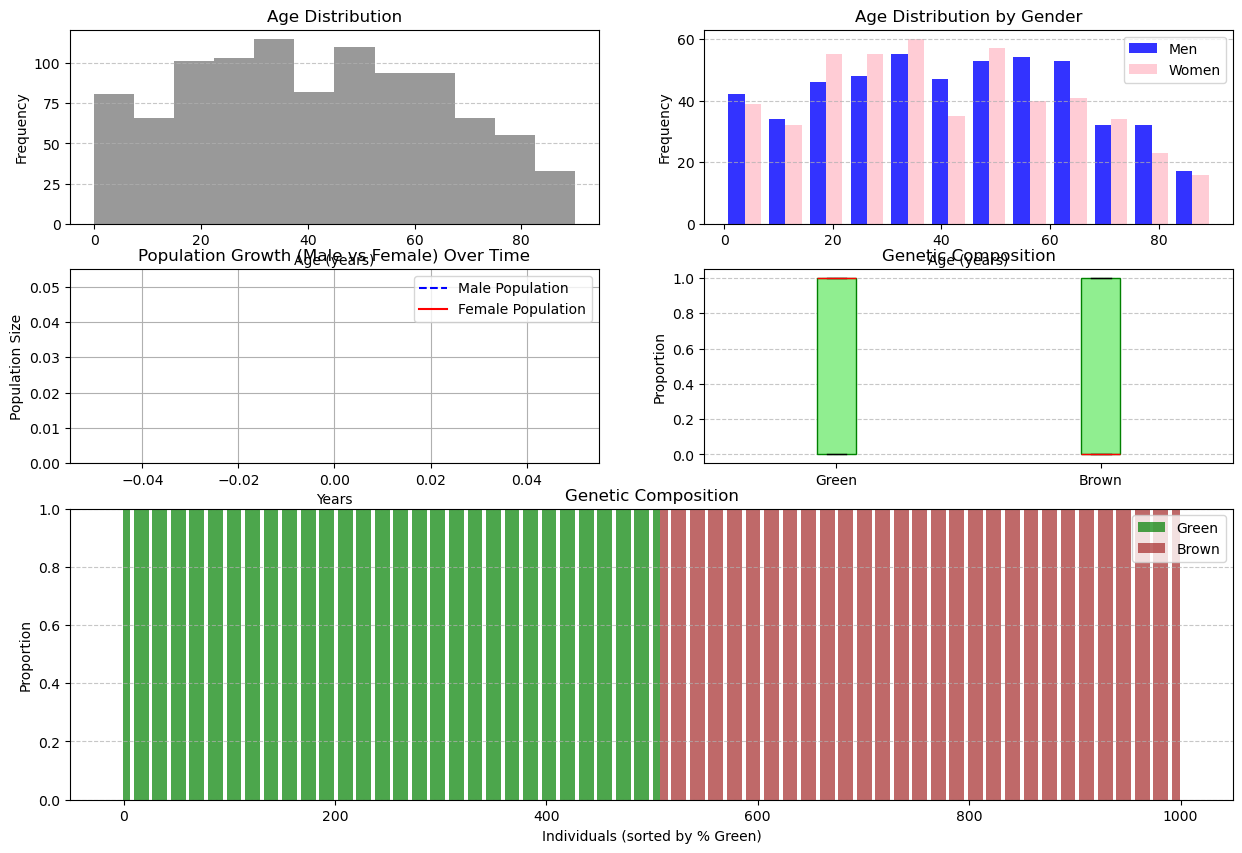

In [95]:
visualizer.plot_all()

In [97]:
population.evolve(500)

In [99]:
population.stat

{'elapsed_years': 500,
 'population_size': 4290,
 'annual_growth_rate_percent': 0.291,
 'min_age': 0,
 'max_age': 81,
 'average_age': 29.641491841491842,
 'gender_ratio': {'male': 2174, 'female': 2116, 'ratio': 1.0274102079395084}}

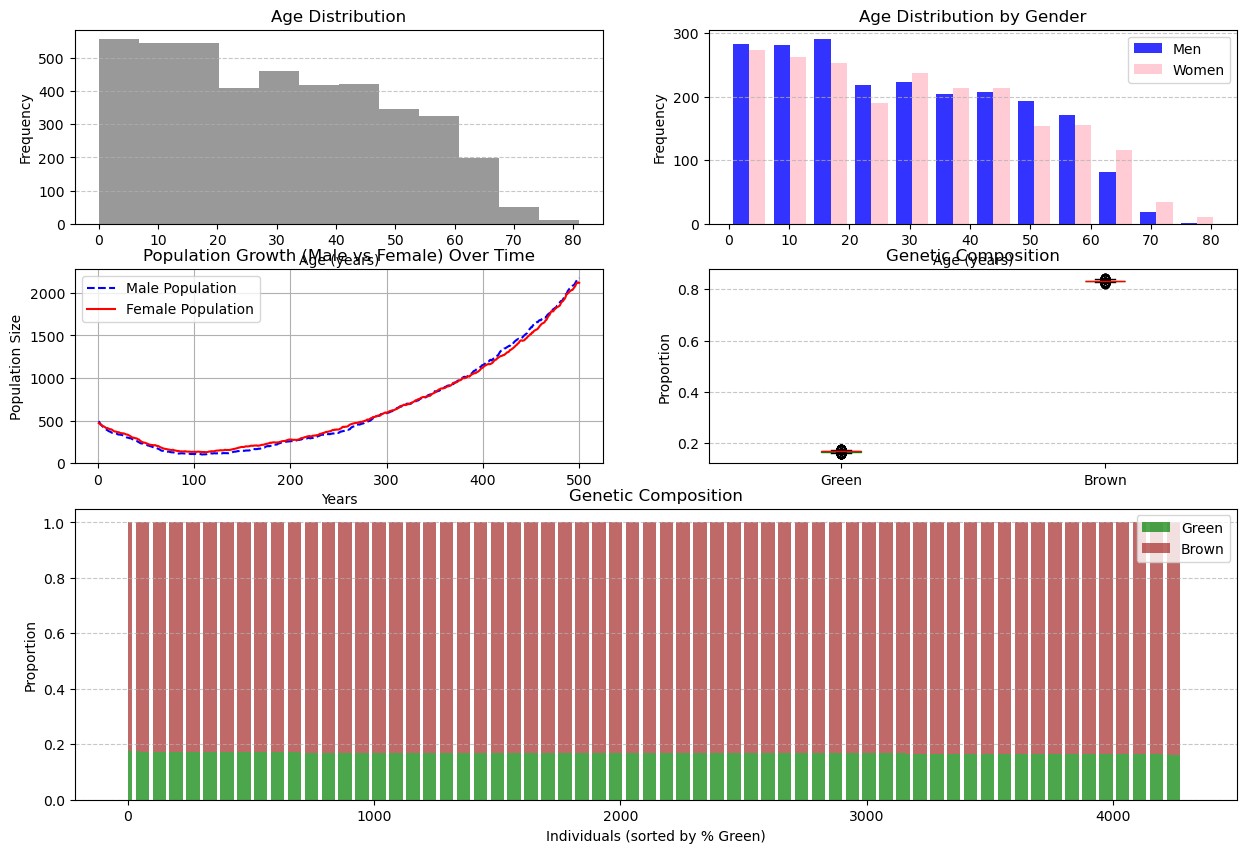

In [101]:
visualizer.plot_all()